In [ ]:
import xarray as xr
import numpy as np
import tqdm as tq
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from toolbar.filter import MovingAverageFilter
from toolbar.masked import masked   # 气象工具函数
from toolbar.K_Mean import K_Mean, plot_test

# 数据读取
data_year = ['1961', '2022']
# 读取CN05.1逐日最高气温数据
CN051_1 = xr.open_dataset(r"E:\data\CN05.1\1961_2021\CN05.1_Tmax_1961_2021_daily_025x025.nc")
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
CN051 = xr.concat([CN051_1, CN051_2], dim='time')
try:
    Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
except:
    Tmax = xr.concat([CN051_1, CN051_2], dim='time')
    Tmax = masked(Tmax, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域温度
    Tmax = Tmax.sel(time=Tmax['time.month'].isin([6, 7, 8])).groupby('time.year')  # 截取夏季数据
    Tmax_5Day_filt = np.array([[[MovingAverageFilter(iyear[1]['tmax'].data[:, i, j], 'lowpass', [5], np.nan).filted() for j in range(283)] for i in range(163)] for iyear in tq.tqdm(Tmax)])  # 5天滑动平均
    Tmax_5Day_filt = Tmax_5Day_filt.transpose(0, 3, 1, 2) # 转换为(year, day, lat, lon)格式
    Tmax_5Day_filt = xr.DataArray(Tmax_5Day_filt,
                                  coords=[[str(i) for i in range(eval(data_year[0]), eval(data_year[1]) + 1)],
                                          [str(i) for i in range(1, 88 + 1)],
                                          CN051_2['lat'].data,
                                          CN051_2['lon'].data],
                                  dims=['year', 'day', 'lat', 'lon'], )
    Tmax_5Day_filt.to_netcdf(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
    del Tmax

zone_stations = masked((CN051_2-CN051_2+1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
t95 = CN051.quantile(0.95, dim='time')['tmax']

In [92]:
EHD = Tmax_5Day_filt - t95

In [61]:
EHD = Tmax_5Day_filt - 35

In [93]:
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
S_th = 0.45
EHD20 = EHD.where(EHDstations_zone >= S_th, np.nan)  # 提取极端高温日占比大于10%
# 获取EHD20的年份和日
EHD20_time = np.zeros((EHD20['year'].size, EHD20['day'].size))
for iyear in range(EHD20['year'].size):
    for iday in range(EHD20['day'].size):
        EHD20_time[iyear, iday] = f"{iyear + 1961}{iday:02d}"

In [94]:
bridge = []
EHD20_time = np.where(EHDstations_zone >= S_th, EHD20_time, np.nan)  # 提取极端高温日占比大于10%
for i in EHD20_time:
    for j in i:
        if not np.isnan(j):
            bridge.append(j)
EHD20_time = np.array(bridge)
EHD20 = masked(EHD20, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 减去非研究地区
EHD20 = EHD20.data.reshape(-1, 163*283)
EHD20 = pd.DataFrame(EHD20).dropna(axis=0, how='all')
EHD20_ = EHD20.dropna(axis=1, how='all')

In [95]:
EHD20_time.shape

(546,)

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.p

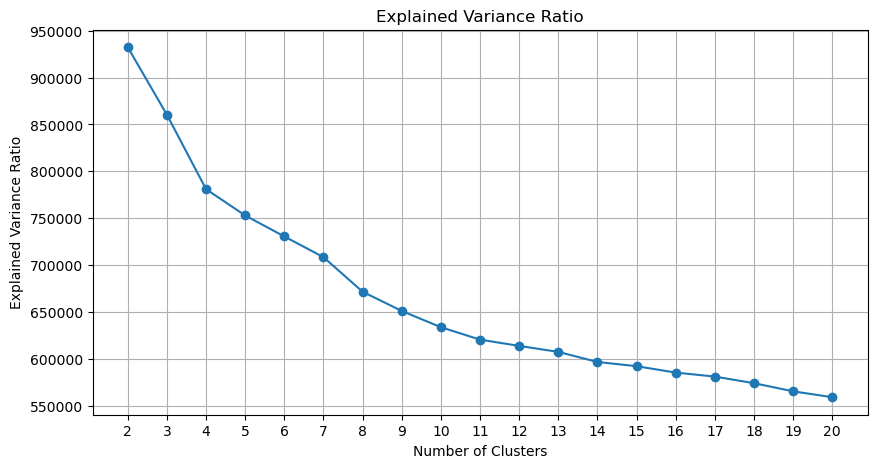

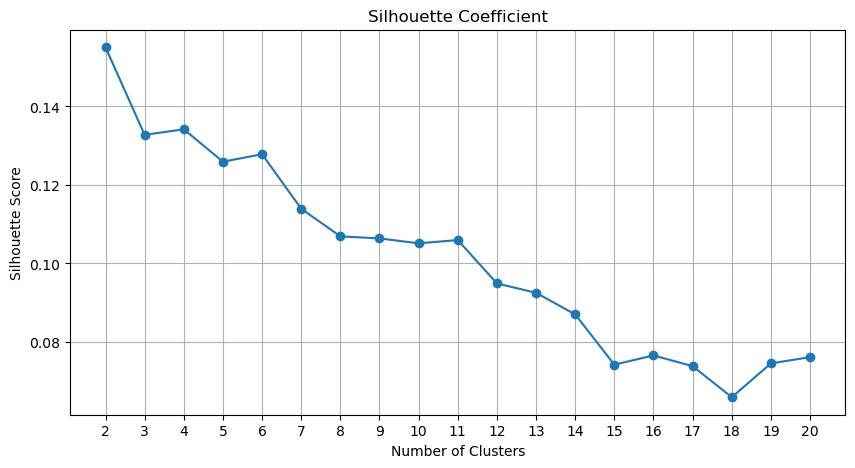

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\86136\.c

Cluster 0: 图像索引 [  5   6  13  16  17  27  28  42  43  44  45  46  47  48  49  64  71  74
  75  76  77  78  79  91  92  93  94  95  98 113 129 130 131 132 138 139
 140 154 155 158 159 165 166 167 181 182 203 204 205 206 207 211 212 228
 247 252 253 254 255 256 284 285 286 287 354 382 383 384 385 398 399 400
 401 402 412 413 414 415 416 417 425 426 458 459 460 464 516]


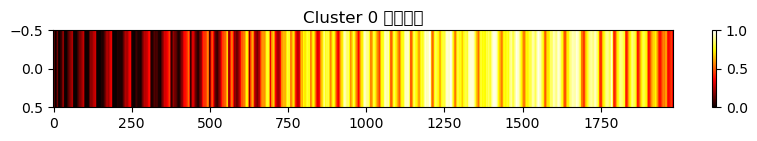

Cluster 1: 图像索引 [  7   8   9  10  11  18  19  80  81  82  85 109 110 111 112 133 134 135
 136 141 145 146 147 151 152 153 161 162 163 190 196 197 208 209 229 230
 248 249 250 251 257 258 263 264 265 266 267 272 273 274 275 280 288 289
 296 297 298 301 306 307 308 309 310 319 320 321 322 323 324 325 328 329
 330 331 332 337 343 344 345 346 347 360 361 362 363 364 370 371 379 380
 381 386 418 419 427 428 429 430 431 432 433 434 441 442 446 447 448 449
 450 451 452 453 454 455 465 474 475 476 477 478 485 486 487 504 505 506
 507 508 509 510 513 514 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 535 536 537 538 539 540 541 542 543]


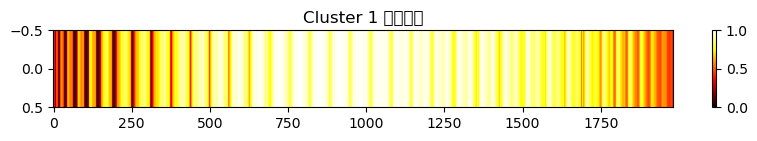

Cluster 2: 图像索引 [  0   1   2   3  14  15  20  21  22  23  24  26  29  30  31  32  33  34
  35  36  37  38  39  40  41  50  51  52  53  54  55  56  57  58  59  60
  61  65  66  67  72  73  86  87  88  89  96  97  99 100 101 102 103 104
 105 106 107 108 114 115 116 117 128 137 142 143 144 148 149 160 168 170
 171 172 173 174 183 184 185 186 187 188 189 192 193 194 195 198 200 202
 210 213 214 215 216 217 218 219 220 221 222 226 227 236 237 238 244 245
 246 259 269 270 271 276 277 278 279 281 282 283 302 303 304 305 311 312
 313 314 315 333 334 335 336 338 339 340 341 348 355 356 359 365 366 367
 368 369 372 373 374 375 376 377 378 403 404 405 406 407 408 409 410 411
 445 456 457 461 466 467 468 469 479 480 481 482 483 484 489 490 491 511
 512]


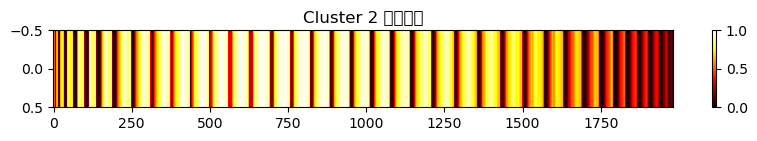

Cluster 3: 图像索引 [  4  12  25  62  63  68  69  70  83  84  90 118 119 120 121 122 123 124
 125 126 127 150 156 157 164 169 175 176 177 178 179 180 191 199 201 223
 224 225 231 232 233 234 235 239 240 241 242 243 260 261 262 268 290 291
 292 293 294 295 299 300 316 317 318 326 327 342 349 350 351 352 353 357
 358 387 388 389 390 391 392 393 394 395 396 397 420 421 422 423 424 435
 436 437 438 439 440 443 444 462 463 470 471 472 473 488 492 493 494 495
 496 497 498 499 500 501 502 503 515 517 518 544 545]


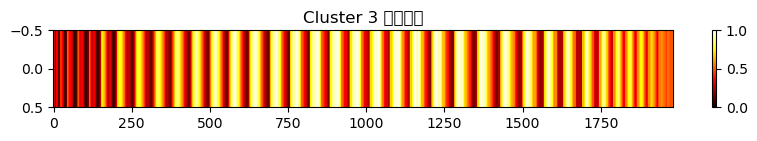

196145.0
196146.0
196179.0
196240.0
196241.0
196435.0
196436.0
196646.0
196647.0
196648.0
196649.0
196655.0
196658.0
196659.0
196660.0
196743.0
196767.0
196779.0
196780.0
196781.0
196782.0
196783.0
196784.0
196955.0
196956.0
196957.0
196958.0
196959.0
197067.0
197155.0
197651.0
197659.0
197660.0
197661.0
197762.0
197763.0
197764.0
197863.0
197864.0
197880.0
197881.0
198051.0
198052.0
198053.0
198669.0
198670.0
199145.0
199146.0
199149.0
199150.0
199151.0
199253.0
199254.0
199459.0
200050.0
200136.0
200137.0
200138.0
200148.0
200149.0
200451.0
200452.0
200453.0
200454.0
201337.0
201374.0
201375.0
201376.0
201448.0
201559.0
201560.0
201561.0
201562.0
201649.0
201670.0
201671.0
201672.0
201673.0
201674.0
201675.0
201747.0
201748.0
201866.0
201867.0
201868.0
201952.0
202256.0
---0------0------0------0------0------0------0------0------0------0---
196147.0
196148.0
196149.0
196150.0
196151.0
196242.0
196243.0
196785.0
196786.0
196787.0
196858.0
197151.0
197152.0
197153.0
197154.0
197662.0
19

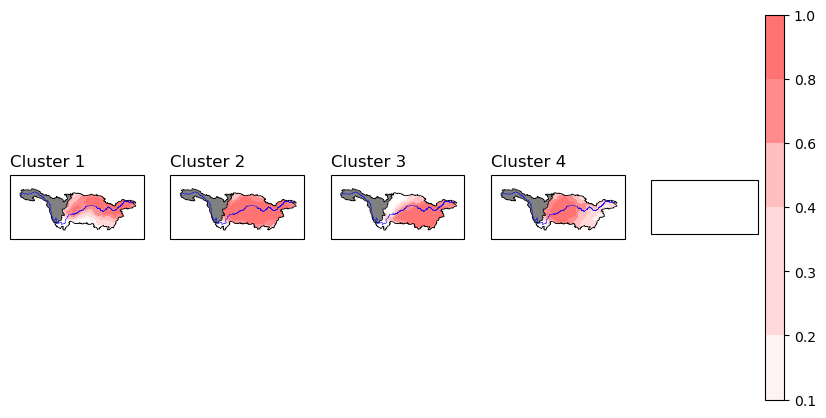

In [98]:
from cartopy.io.shapereader import Reader

plot_test(EHD20_.to_numpy(), max_clusters=20)
K_s = 4
K = K_Mean(EHD20_.to_numpy(), K_s)
import  cmaps
# 绘制三种聚类的平均分布图
fig = plt.figure(figsize=(10, 5))
for cluster in range(K_s):
    ax = fig.add_subplot(1, K_s+1, cluster+1, projection=ccrs.PlateCarree())
    ax.set_title(f"Cluster {cluster+1}", loc='left')
    ax.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
    ax.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.2)
    ax.set_extent([88, 124, 22, 38])
    KM = []
    for i in K[cluster]['indices']:
        KM.append(EHD20.iloc[i].to_numpy())
        print(EHD20_time[i])
    KM = np.array(KM).mean(axis=0)
    con = ax.contourf(CN051_2['lon'], CN051_2['lat'], KM.reshape(163, 283),
                cmap=cmaps.GMT_polar[10:-4], transform=ccrs.PlateCarree(), levels=[0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1])

    print(f'---{cluster}---'*10)
ax = fig.add_subplot(1, K_s+1, K_s+1, projection=ccrs.PlateCarree())
plt.colorbar(con, ax=ax)
plt.show()